In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data_dir = Path("./samples/")


images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print(f"Number of images found: {len(images)}")
print(f"Number of labels found: {len(labels)}")
print(f"Number of unique characters: {len(characters)}")
print(f"Characters present: {characters}")

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: {'w', '7', 'x', '4', 'n', '3', 'p', 'd', 'm', 'g', '6', '8', 'b', '2', 'c', 'e', 'y', '5', 'f'}


In [3]:
batch_size = 16


img_width = 200
img_height = 50


downsample_factor = 4


max_length = max([len(label) for label in labels])

In [4]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)


num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
   
    size = len(images)
   
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    train_samples = int(size * train_size)
   
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]] 
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels=1)
   
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img = tf.image.resize(img, [img_height, img_width])
   
    img = tf.transpose(img, perm=[1, 0, 2])
   
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    return {"image": img, "label": label}

In [5]:
X_train, X_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

print(f"X_Train shape: {X_train.shape}")
print(f"y_Train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_Train shape: (936,)
y_Train shape: (936,)
X_valid shape: (104,)
y_valid shape: (104,)


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

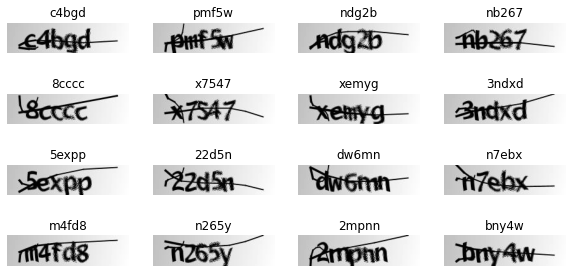

In [7]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [8]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
        
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        
        return y_pred
    
def build_model():
   
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    
   
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
    
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
   
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)
    
    
    output = CTCLayer(name="ctc_loss")(labels, x)
    
    
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    opt = keras.optimizers.Adam()
    
    model.compile(optimizer=opt)
    return model

In [9]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [10]:
%%time
epochs = 100
early_stopping_patience = 10


early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100
59/59 [==============================] - 12s 199ms/step - loss: 20.3364 - val_loss: 16.3788
Epoch 2/100
59/59 [==============================] - 10s 163ms/step - loss: 16.3555 - val_loss: 16.3731
Epoch 3/100
59/59 [==============================] - 10s 174ms/step - loss: 16.3543 - val_loss: 16.3763
Epoch 4/100
59/59 [==============================] - 10s 164ms/step - loss: 16.3492 - val_loss: 16.3685
Epoch 5/100
59/59 [==============================] - 10s 174ms/step - loss: 16.3519 - val_loss: 16.3541
Epoch 6/100
59/59 [==============================] - 10s 174ms/step - loss: 16.3363 - val_loss: 16.3350
Epoch 7/100
59/59 [==============================] - 9s 158ms/step - loss: 16.3346 - val_loss: 16.3403
Epoch 8/100
59/59 [==============================] - 10s 171ms/step - loss: 16.3238 - val_loss: 16.2875
Epoch 9/100
59/59 [==============================] - 10s 177ms/step - loss: 16.3009 - val_loss: 16.2705
Epoch 10/100
59/59 [==============================] - 10s 177ms/s

59/59 [==============================] - 10s 167ms/step - loss: 0.4073 - val_loss: 2.0111
Epoch 81/100
59/59 [==============================] - 10s 167ms/step - loss: 0.3975 - val_loss: 1.9067
Epoch 82/100
59/59 [==============================] - 10s 167ms/step - loss: 0.3954 - val_loss: 2.0497
CPU times: user 37min 40s, sys: 1min 10s, total: 38min 50s
Wall time: 14min 15s


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)           

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


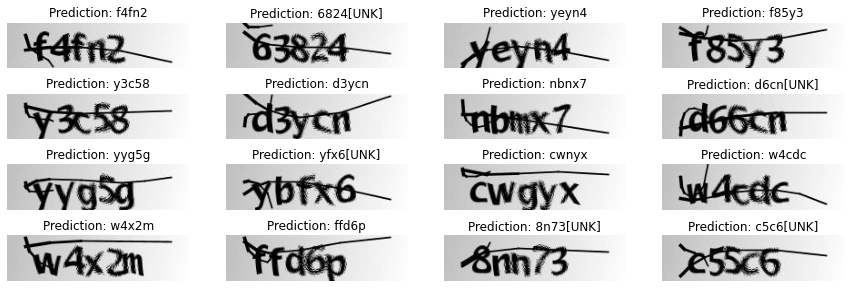

In [11]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, : max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")        
plt.show()